# Transfer learning with Model Maker - Speech recognition (ENG)

En este notebook (a ejecutar en Colab) se lleva a cabo el transfer learning sobre un modelo de reconocimiento de lenguaje en forma de detección de palabras de activación. La mayoría de código está redactado por TensorFlow y es público, pero hay otra parte escrita por mí (como la cuantización del modelo y la forma de llevar a cabo inferencia con el modelo cuantizado).

*Había un fallo a la hora de generar la matriz de confusión que he corregido en este script

##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Retrain a speech recognition model with TensorFlow Lite Model Maker


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/speech_recognition"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/speech_recognition.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/speech_recognition.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/speech_recognition.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>

</table>


In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker) to train a speech recognition model that can classify spoken words or short phrases using one-second sound samples. The Model Maker library uses transfer learning to retrain an existing TensorFlow model with a new dataset, which reduces the amount of sample data and time required for training. 

By default, this notebook retrains the model (BrowserFft, from the [TFJS Speech Command Recognizer](https://github.com/tensorflow/tfjs-models/tree/master/speech-commands#speech-command-recognizer)) using a subset of words from the [speech commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) (such as "up", "down", "left", and "right"). Then it exports a TFLite model that you can run on a mobile device or embedded system (such as a Raspberry Pi). It also exports the trained model as a TensorFlow SavedModel.

This notebook is also designed to accept a custom dataset of WAV files, uploaded to Colab in a ZIP file. The more samples you have for each class, the better your accuracy will be, but because the transfer learning process uses feature embeddings from the pre-trained model, you can still get a fairly accurate model with only a few dozen samples in each of your classes.

**Note:** The model we'll be training is optimized for speech recognition with one-second samples. If you want to perform more generic audio classification (such as detecting different types of music), we suggest you instead follow [this Colab to retrain an audio classifier](https://colab.sandbox.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/audio_classification.ipynb).

If you want to run the notebook with the default speech dataset, you can run the whole thing now by clicking **Runtime > Run all** in the Colab toolbar. However, if you want to use your own dataset, then continue down to [Prepare the dataset](#scrollTo=cBsSAeYLkc1Z) and follow the instructions there.


### Import the required packages


You"ll need TensorFlow, TFLite Model Maker, and some modules for audio manipulation, playback, and visualizations.

In [2]:
!sudo apt -y install libportaudio2
!pip install "tensorflow==2.8"
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install "tflite-model-maker==0.4.0"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (107 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [3]:
#!pip freeze > ./requirements_freeze.txt
!pip freeze

absl-py==1.2.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.4
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.6.15
cffi==1.15.1
cftime==1.6.1
chardet==3.0.4
charset-normalizer==2.1.0
click==7.1.2
clikit==0.6.2
cloudpickle==1.3.0
cmake==3.22.6
cmdstanpy==1.0.4
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.6
Cython==0.29.32
daft==0.0.4
dask==2.12.0
dataclasses==0.6
datascience==0.17.5
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
deprecat==2.1.1
descart

In [4]:
!sudo rm -r ./sample_data

In [7]:
import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.9.1
Model Maker Version: 0.4.0


## Prepare the dataset

To train with the default speech dataset, just run all the code below as-is.

But if you want to train with your own speech dataset, follow these steps:

**Note:** 
The model you'll retrain expects input data to be roughly one second of audio at 44.1 kHz. Model Maker perfoms automatic resampling for the training dataset, so there's no need to resample your dataset if it has a sample rate other than 44.1 kHz. But beware that audio samples longer than one second will be split into multiple one-second chunks, and the final chunk will be discarded if it's shorter than one second.

1. Be sure each sample in your dataset is in **WAV file format, about one second long**. Then create a ZIP file with all your WAV files, organized into separate subfolders for each classification. For example, each sample for a speech command "yes" should be in a subfolder named "yes". Even if you have only one class, the samples must be saved in a subdirectory with the class name as the directory name. (This script assumes your dataset **is not split** into train/validation/test sets and performs that split for you.)
2. Click the **Files** tab in the left panel and just drag-drop your ZIP file there to upload it.
3. Use the following drop-down option to set **`use_custom_dataset`** to True.
4. Then skip to [Prepare a custom audio dataset](#scrollTo=EobYerLQkiF1) to specify your ZIP filename and dataset directory name.




In [8]:
use_custom_dataset = True #@param ["False", "True"] {type:"raw"}

### Generate a background noise dataset

Whether you're using the default speech dataset or a custom dataset, you should have a good set of background noises so your model can distinguish speech from other noises (including silence). 

Because the following background samples are provided in WAV files that are a minute long or longer, we need to split them up into smaller one-second samples so we can reserve some for our test dataset. We'll also combine a couple different sample sources to build a comprehensive set of background noises and silence:

In [9]:
"""
tf.keras.utils.get_file("speech_commands_v0.01.tar.gz",
                        "http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz",
                        cache_dir="./",
                        cache_subdir="dataset-speech",
                        extract=True)
"""
tf.keras.utils.get_file("background_audio.zip",
                        "https://storage.googleapis.com/download.tensorflow.org/models/tflite/sound_classification/background_audio.zip",
                        cache_dir="./",
                        cache_subdir="dataset-background",
                        extract=True)


1072437/1072437 [==============================] - 0s 0us/step


'./dataset-background/background_audio.zip'

**Note:** Although there is a newer version available, we're using v0.01 of the speech commands dataset because it's a smaller download. v0.01 includes 30 commands, while v0.02 adds five more ("backward", "forward", "follow", "learn" and "visual").

In [10]:
# Create a list of all the background wav files
files = glob.glob(os.path.join("./dataset-speech/_background_noise_", "*.wav").replace("\\", "/"))
files = files + glob.glob(os.path.join("./dataset-background", "*.wav").replace("\\", "/"))

background_dir = "./background"
os.makedirs(background_dir, exist_ok=True)

# Loop through all files and split each into several one-second wav files
for file in files:
  filename = os.path.basename(os.path.normpath(file))
  print("Splitting", filename)
  name = os.path.splitext(filename)[0]
  rate = librosa.get_samplerate(file)
  length = round(librosa.get_duration(filename=file))
  for i in range(length - 1):
    start = i * rate
    stop = (i * rate) + rate
    data, _ = sf.read(file, start=start, stop=stop)
    sf.write(os.path.join(background_dir, name + str(i) + ".wav").replace("\\", "/"), data, rate)

Splitting silence.wav
Splitting throat_clearing.wav


### Prepare the speech commands dataset (NOT NEEDED)

We already downloaded the speech commands dataset, so now we just need to prune the number of classes for our model.

This dataset includes over 30 speech command classifications, and most of them have over 2,000 samples. But because we're using transfer learning, we don't need that many samples. So the following code does a few things:

+ Specify which classifications we want to use, and delete the rest.
+ Keep only 150 samples of each class for training (to prove that transfer learning works well with smaller datasets and simply to reduce the training time).
+ Create a separate directory for a test dataset so we can easily run inference with them later.

In [11]:
"""
if not use_custom_dataset:
  commands = [ "up", "down", "left", "right", "go", "stop", "on", "off", "background"]
  dataset_dir = "./dataset-speech"
  test_dir = "./dataset-test"

  # Move the processed background samples
  shutil.move(background_dir, os.path.join(dataset_dir, "background"))   

  # Delete all directories that are not in our commands list
  dirs = glob.glob(os.path.join(dataset_dir, "*/"))
  for dir in dirs:
    name = os.path.basename(os.path.normpath(dir))
    if name not in commands:
      shutil.rmtree(dir)

  # Count is per class
  sample_count = 150
  test_data_ratio = 0.2
  test_count = round(sample_count * test_data_ratio)

  # Loop through child directories (each class of wav files)
  dirs = glob.glob(os.path.join(dataset_dir, "*/"))
  for dir in dirs:
    files = glob.glob(os.path.join(dir, "*.wav"))
    random.seed(42)
    random.shuffle(files)
    # Move test samples:
    for file in files[sample_count:sample_count + test_count]:
      class_dir = os.path.basename(os.path.normpath(dir))
      os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
      os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    # Delete remaining samples
    for file in files[sample_count + test_count:]:
      os.remove(file)
"""

'\nif not use_custom_dataset:\n  commands = [ "up", "down", "left", "right", "go", "stop", "on", "off", "background"]\n  dataset_dir = "./dataset-speech"\n  test_dir = "./dataset-test"\n\n  # Move the processed background samples\n  shutil.move(background_dir, os.path.join(dataset_dir, "background"))   \n\n  # Delete all directories that are not in our commands list\n  dirs = glob.glob(os.path.join(dataset_dir, "*/"))\n  for dir in dirs:\n    name = os.path.basename(os.path.normpath(dir))\n    if name not in commands:\n      shutil.rmtree(dir)\n\n  # Count is per class\n  sample_count = 150\n  test_data_ratio = 0.2\n  test_count = round(sample_count * test_data_ratio)\n\n  # Loop through child directories (each class of wav files)\n  dirs = glob.glob(os.path.join(dataset_dir, "*/"))\n  for dir in dirs:\n    files = glob.glob(os.path.join(dir, "*.wav"))\n    random.seed(42)\n    random.shuffle(files)\n    # Move test samples:\n    for file in files[sample_count:sample_count + test_count

### Prepare a custom dataset

If you want to train the model with our own speech dataset, you need to upload your samples as WAV files in a ZIP ([as described above](#scrollTo=cBsSAeYLkc1Z)) and modify the following variables to specify your dataset:

In [12]:
from google.colab import drive
drive.mount("/content/drive")

!sudo cp "/content/drive/MyDrive/Colab Notebooks/TL_speech_commands_eng_v01.zip" /content

Mounted at /content/drive


In [14]:
if use_custom_dataset:
  # Specify the ZIP file you uploaded:
  !unzip TL_speech_commands_eng_v01.zip
  # Specify the unzipped path to your custom dataset
  # (this path contains all the subfolders with classification names):
  dataset_dir = "./speech_commands"

Streaming output truncated to the last 5000 lines.
  inflating: speech_commands/15-right/c948d727_nohash_3.wav  
  inflating: speech_commands/15-right/c948d727_nohash_4.wav  
  inflating: speech_commands/15-right/c9b653a0_nohash_0.wav  
  inflating: speech_commands/15-right/c9b653a0_nohash_1.wav  
  inflating: speech_commands/15-right/c9b653a0_nohash_2.wav  
  inflating: speech_commands/15-right/c9b653a0_nohash_3.wav  
  inflating: speech_commands/15-right/caa4779f_nohash_0.wav  
  inflating: speech_commands/15-right/caa4779f_nohash_1.wav  
  inflating: speech_commands/15-right/caa7feaf_nohash_0.wav  
  inflating: speech_commands/15-right/cae62f38_nohash_0.wav  
  inflating: speech_commands/15-right/caedb73a_nohash_0.wav  
  inflating: speech_commands/15-right/caf1803e_nohash_0.wav  
  inflating: speech_commands/15-right/cb164eea_nohash_0.wav  
  inflating: speech_commands/15-right/cb2929ce_nohash_0.wav  
  inflating: speech_commands/15-right/cb2929ce_nohash_1.wav  
  inflating: speech

After changing the filename and path name above, you're ready to train the model with your custom dataset. In the Colab toolbar, select **Runtime > Run all** to run the whole notebook.

The following code integrates our new background noise samples into your dataset and then separates a portion of all samples to create a test set.

In [15]:
def move_background_dataset(dataset_dir):
  dest_dir = os.path.join(dataset_dir, "background").replace("\\", "/")
  if os.path.exists(dest_dir):
    files = glob.glob(os.path.join(background_dir, "*.wav").replace("\\", "/"))
    for file in files:
      shutil.move(file, dest_dir)
  else:
    shutil.move(background_dir, dest_dir)

In [16]:
if use_custom_dataset:
  # Move background samples into custom dataset
  move_background_dataset(dataset_dir)

  # Now we separate some of the files that we'll use for testing:
  test_dir = "./dataset-test"
  test_data_ratio = 0.4
  dirs = glob.glob(os.path.join(dataset_dir, "*/").replace("\\", "/"))
  for dir in dirs:
    files = glob.glob(os.path.join(dir, "*.wav").replace("\\", "/"))
    test_count = round(len(files) * test_data_ratio)
    random.seed(2022)
    random.shuffle(files)
    # Move test samples:
    for file in files[:test_count]:
      class_dir = os.path.basename(os.path.normpath(dir))
      os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
      os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    print("Moved", test_count, "files from", class_dir)

Moved 902 files from 06-six
Moved 906 files from 16-yes
Moved 902 files from 10-on
Moved 894 files from 17-no
Moved 896 files from 01-one
Moved 12 files from background
Moved 902 files from 14-left
Moved 902 files from 11-off
Moved 908 files from 12-up
Moved 920 files from 07-seven
Moved 895 files from 02-two
Moved 891 files from 08-eight
Moved 896 files from 09-nine
Moved 910 files from 05-five
Moved 902 files from 15-right
Moved 898 files from 00-zero
Moved 904 files from 04-four
Moved 902 files from 13-down
Moved 883 files from 03-three


### Play a sample

To be sure the dataset looks correct, let's play at a random sample from the test set:

In [17]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, "*/*.wav").replace("\\", "/"))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f"Class: {class_name}")
  print(f"File: {audio_path}")
  print(f"Sample rate: {sample_rate}")
  print(f"Sample length: {len(audio_data)}")

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: 09-nine
File: /content/dataset-test/09-nine/964e8cfd_nohash_0.wav
Sample rate: 16000
Sample length: 16000


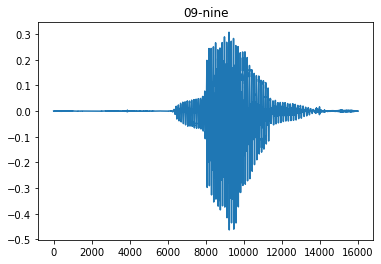

In [18]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

## Define the model


When using Model Maker to retrain any model, you have to start by defining a model spec. The spec defines the base model from which your new model will extract feature embeddings to begin learning new classes. The spec for this speech recognizer is based on the pre-trained [BrowserFft model from TFJS](https://github.com/tensorflow/tfjs-models/tree/master/speech-commands#speech-command-recognizer).

**The model expects input as an audio sample that's 44.1 kHz, and just under a second long: the exact sample length must be 44034 frames.**

You don't need to do any resampling with your training dataset. Model Maker takes care of that for you. **But when you later run inference, you must be sure that your input matches that expected format.**

All you need to do here is instantiate the [`BrowserFftSpec`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/BrowserFftSpec):


In [19]:
spec = audio_classifier.BrowserFftSpec()

18467/18467 [==============================] - 0s 0us/step


1680432/1680432 [==============================] - 0s 0us/step


## Load your dataset 

Now you need to load your dataset according to the model specifications. Model Maker includes the [`DataLoader`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/DataLoader) API, which will load your dataset from a folder and ensure it's in the expected format for the model spec.

We already reserved some test files by moving them to a separate directory, which makes it easier to run inference with them later. Now we'll create a `DataLoader` for each split: the training set, the validation set, and the test set.

#### Load the speech commands dataset (NOT NEEDED)


In [20]:
"""
if not use_custom_dataset:
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)
"""

'\nif not use_custom_dataset:\n  train_data_ratio = 0.8\n  train_data = audio_classifier.DataLoader.from_folder(\n      spec, dataset_dir, cache=True)\n  train_data, validation_data = train_data.split(train_data_ratio)\n  test_data = audio_classifier.DataLoader.from_folder(\n      spec, test_dir, cache=True)\n'

#### Load a custom dataset

**Note:** Setting `cache=True` is important to make training faster (especially when the dataset must be re-sampled) but it will also require more RAM to hold the data. If you use a very large custom dataset, caching might exceed your RAM capacity.

In [21]:
if use_custom_dataset:
  train_data_ratio = 0.9
  train_data = audio_classifier.DataLoader.from_folder(spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(spec, test_dir, cache=True)


## Train the model


Now we'll use the Model Maker [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) function to create a model based on our model spec and training dataset, and begin training.

If you're using a custom dataset, you might want to change the batch size as appropriate for the number of samples in your train set.

**Note:** The first epoch takes longer because it must create the cache. 

In [22]:
# If your dataset has fewer than 100 samples per class, you might want to try a smaller than 25 batch size
batch_size = 50
epochs = 25
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32)       

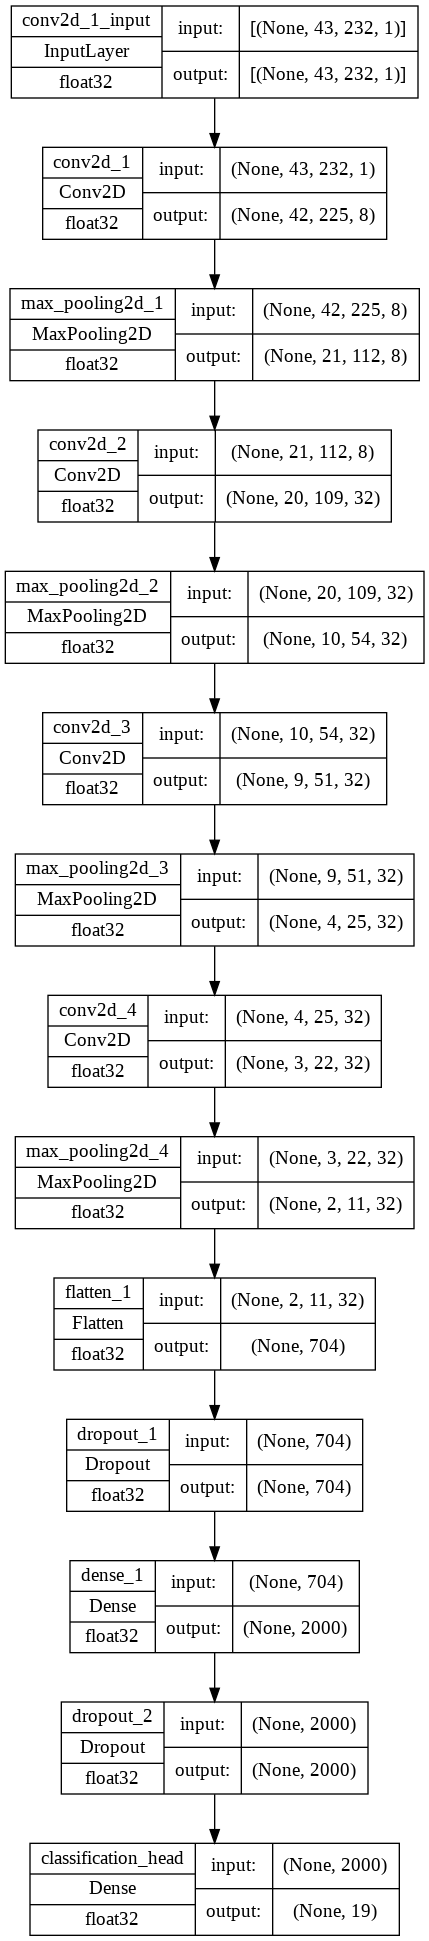

In [23]:
from keras.utils.vis_utils import plot_model

plot_model(model.model, to_file="TL_original_model.png", show_shapes=True, show_dtype=True, show_layer_names=True)

## Review the model performance

Even if the accuracy/loss looks good from the training output above, it's important to also run the model using test data that the model has not seen yet, which is what the `evaluate()` method does here:

In [24]:
model.evaluate(train_data)

685/685 [==============================] - 1827s 3s/step - loss: 0.0297 - acc: 0.9903


[0.02965235337615013, 0.9902766346931458]

In [25]:
model.evaluate(validation_data)

77/77 [==============================] - 205s 3s/step - loss: 0.2297 - acc: 0.9622


[0.22969883680343628, 0.9622176885604858]

In [26]:
model.evaluate(test_data)

508/508 [==============================] - 1341s 3s/step - loss: 0.1807 - acc: 0.9692


[0.18070769309997559, 0.9691833853721619]

*Info on loss metric:* https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model

### View the confusion matrix

When training a classification model such as this one, it's also useful to inspect the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed visual representation of how well your classifier performs for each classification in your test data.

In [27]:
def show_confusion_matrix(confusion, test_labels, data_set):
  """Compute confusion matrix and normalize."""
  confusion_normalized = [confusion[i].astype("float") / confusion.sum(axis=1)[i] for i in range(len(confusion))]
  sns.set(rc = {"figure.figsize":(10,10)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap="Blues", annot=True, fmt=".2f", square=True, cbar=False)
  plt.title(f"Confusion matrix for the {data_set} set")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

1/1 [==============================] - 0s 189ms/step


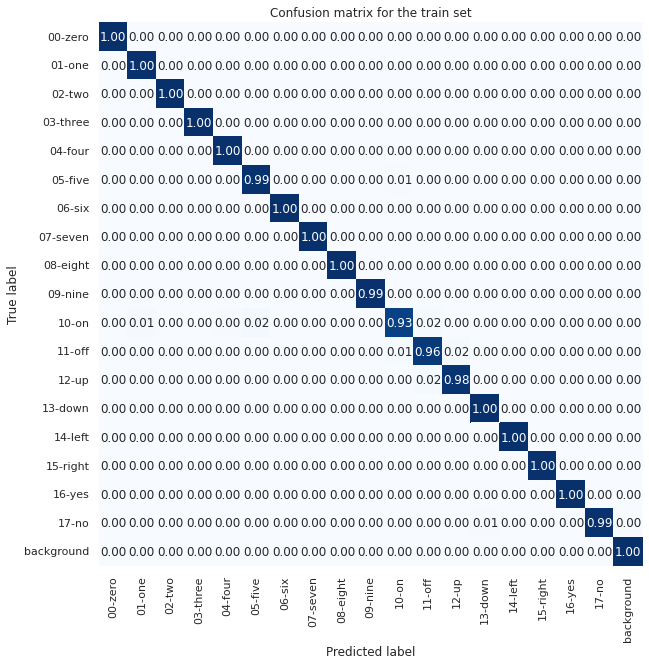

In [28]:
train_confusion_matrix = model.confusion_matrix(train_data)
show_confusion_matrix(train_confusion_matrix.numpy(), train_data.index_to_label, "train")

1/1 [==============================] - 0s 30ms/step


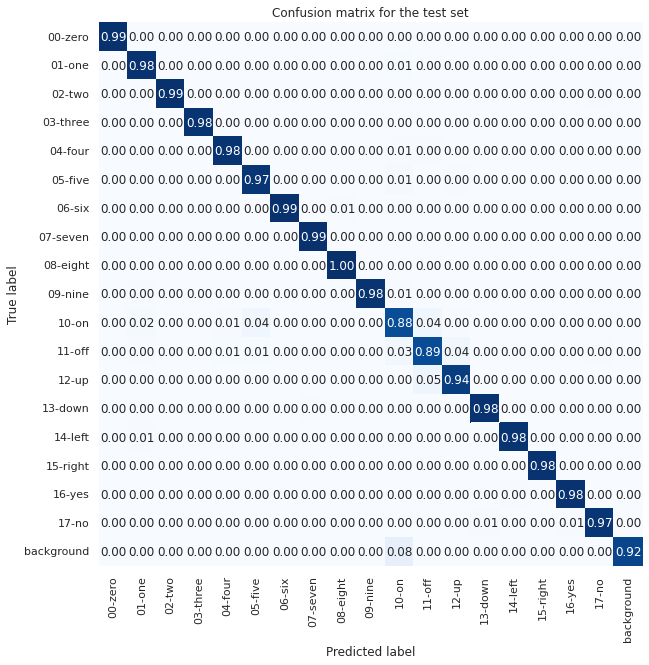

In [29]:
test_confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(test_confusion_matrix.numpy(), test_data.index_to_label, "test")

## Export the TFlite model

The last step is exporting your model into the TensorFlow Lite format for execution on mobile/embedded devices and into the [SavedModel format](https://www.tensorflow.org/guide/saved_model) for execution elsewhere.

When exporting a `.tflite` file from Model Maker, it includes [model metadata](https://www.tensorflow.org/lite/inference_with_metadata/overview) that describes various details that can later help during inference. It even includes a copy of the classification labels file, so you don't need to a separate `labels.txt` file. (In the next section, we show how to use this metadata to run an inference.)

In [30]:
SAVE_PATH = "./models"
TFLITE_FILENAME = "browserfft-speech.tflite"

In [31]:
print(f"Exporting the model to {SAVE_PATH}")
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporting the model to ./models


## Run inference with TF Lite model

Now your TFLite model can be deployed and run using any of the supported [inferencing libraries](https://www.tensorflow.org/lite/guide/inference) or with the new [TFLite AudioClassifier Task API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/audio_classifier). The following code shows how you can run inference with the `.tflite` model in Python.

In [32]:
# This library provides the TFLite metadata API
!pip install -q tflite_support

In [33]:
from tflite_support import metadata
import json

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split("\n")]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json["subgraph_metadata"][0]["input_tensor_metadata"][0]
  input_content_props = input_tensor_metadata["content"]["content_properties"]
  return input_content_props["sample_rate"]

To observe how well the model performs with real samples, run the following code block over and over. Each time, it will fetch a new test sample and run inference with it, and you can listen to the audio sample below.

---prediction---
Class: 10-on
Score: 0.8908115029335022
----truth----
Class: 10-on
File: /content/dataset-test/10-on/ceaadb24_nohash_0.wav
Sample rate: 16000
Sample length: 16000


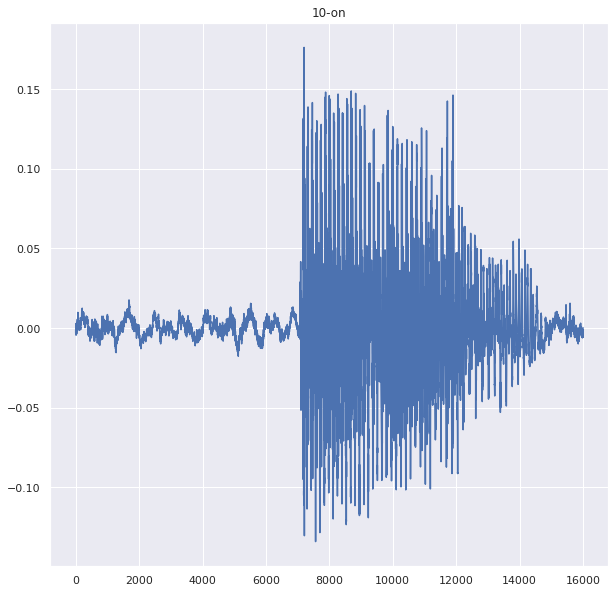

In [34]:
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME).replace("\\", "/")
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]["shape"][1]
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]["index"], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print("---prediction---")
print(f"Class: {label}\nScore: {score}")
print("----truth----")
show_sample(random_audio)

In [35]:
input_details

[{'name': 'audio_preproc_input',
  'index': 0,
  'shape': array([    1, 44032], dtype=int32),
  'shape_signature': array([   -1, 44032], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

Now you can deploy the TF Lite model to your mobile or embedded device. You don't need to download the labels file because you can instead retrieve the labels from `.tflite` file metadata, as shown in the previous inferencing example.

-----

## Quantization of the model

We want to execute this re-trained model in an Edge TPU, so we need to quantize it before deploying it. There are several types of post-quantization (depending on the purpose and on how much do we want to reduce the size of our model) like the weight/hybrid quantization or the full quantization. The one required for the Edge TPU is the full integer-only quantization.

The full integer quantization treats both the weights and the activation values. For the activation values to be quantized, a representative dataset is required for calibration, so that the output of the activation function is mapped to integer values.

In [127]:
representative_arrays = []
sample_rate = get_input_sample_rate(tflite_file)
samples_per_label = 30
samples_per_label_background = 15

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_dir)):

  if dirpath != dataset_dir:
    if dirpath.split("/")[-1] != "background":
      for file in random.sample(filenames, samples_per_label):
        valid = True
        file_full = os.path.join(dirpath, file).replace("\\","/")

        signal, _ = librosa.load(file_full, sr=sample_rate)
        if len(signal) < input_size:
          signal.resize(input_size)
        
        for element in signal:
          if element == float(0):
            valid = False

        if valid:
          signal = np.expand_dims(signal[:input_size], axis=0)

          representative_arrays.append(signal)
    elif dirpath.split("/")[-1] == "background":
      for file in random.sample(filenames, samples_per_label_background):
        valid = True
        file_full = os.path.join(dirpath, file).replace("\\","/")

        signal, _ = librosa.load(file_full, sr=sample_rate)
        if len(signal) < input_size:
          signal.resize(input_size)
        
        for element in signal:
          if element == float(0):
            valid = False

        if valid:
          signal = np.expand_dims(signal[:input_size], axis=0)

          representative_arrays.append(signal)

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters.

In [128]:
def representative_data_gen():
  for representative_array in representative_arrays:
    yield [representative_array]

converter = tf.lite.TFLiteConverter.from_saved_model("./models/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert() # seems that samples that contain signal values equal to float(0) can't be used here -> they yield NaN and the conversion fails

The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:

In [129]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]["dtype"]
print("input: ", input_type)
output_type = interpreter.get_output_details()[0]["dtype"]
print("output: ", output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the Edge TPU.

Finally, we save the quantized model.

In [130]:
import pathlib

print(f"Exporting the quantized model to {SAVE_PATH}")
tflite_models_dir = pathlib.Path(SAVE_PATH)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model
tflite_quant_file = tflite_models_dir/"TL_model_quantized_MM.tflite" # working because it's a pathlib path object
tflite_quant_file.write_bytes(tflite_model_quant)

# Normal byte writing
#with open(os.path.join(tflite_models_dir, "TL_model_quantized_MM.tflite").replace("\\", "/"), "wb") as binary_file:
#  binary_file.write(tflite_model_quant)

Exporting the quantized model to ./models


1492280

We can also export the model with metadata.

In [131]:
from tflite_support.metadata_writers import audio_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils

AudioClassifierWriter = audio_classifier.MetadataWriter
_MODEL_PATH = "./models/TL_model_quantized_MM.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "./models/labels.txt"
# Expected sampling rate of the input audio buffer.
_SAMPLE_RATE = 44100
# Expected number of channels of the input audio buffer. Note, Task library only support single channel so far.
_CHANNELS = 1
_SAVE_TO_PATH = "./models/TL_model_quantized_MM_metadata.tflite"

# Create the metadata writer.
writer = AudioClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), _SAMPLE_RATE, _CHANNELS, [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "AudioClassifier",
  "description": "Identify the most prominent type in the audio clip from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "audio_clip",
          "description": "Input audio clip to be classified.",
          "content": {
            "content_properties_type": "AudioProperties",
            "content_properties": {
              "sample_rate": 44100,
              "channels": 1
            }
          },
          "stats": {
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probability",
          "description": "Scores of the labels respectively.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_properties": {
            }
          },
          "stats": {
            "max": [
              255.0
            ],
            "min": [
              0.0
            ]
          },
        

## Run inference with the quantized model

If model is saved with metadata, we can run inference this way.

---prediction---
Class: 01-one
Score: 255
----truth----
Class: 01-one
File: /content/dataset-test/01-one/063d48cf_nohash_0.wav
Sample rate: 16000
Sample length: 16000


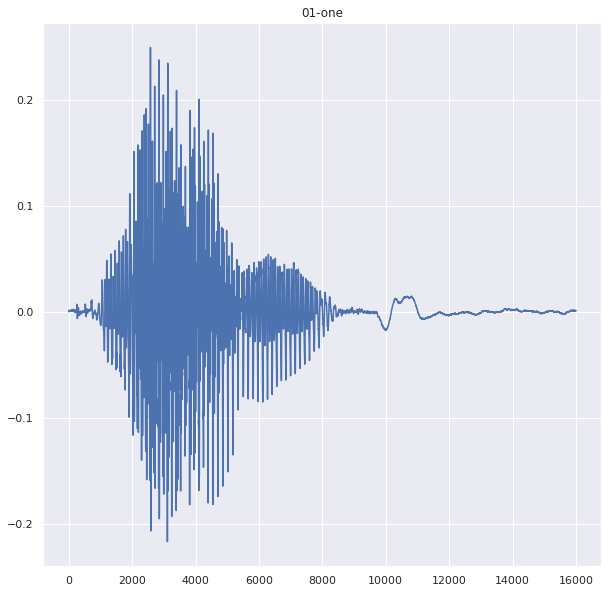

In [132]:
# Get a WAV file for inference and list of labels from the model
tflite_quant_metadata_file = os.path.join(SAVE_PATH, "TL_model_quantized_MM_metadata.tflite").replace("\\", "/")
labels = get_labels(tflite_quant_metadata_file)
random_audio = get_random_audio_file(test_dir)

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(model_path=str(tflite_quant_metadata_file))
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]["shape"][1]
sample_rate = get_input_sample_rate(tflite_quant_metadata_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)

if input_details[0]["dtype"] == np.uint8:
  input_scale, input_zero_point = input_details[0]["quantization"]
  audio_data = audio_data / input_scale + input_zero_point

audio_data = np.expand_dims(audio_data[:input_size], axis=0).astype(input_details[0]["dtype"])

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]["index"], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print("---prediction---")
print(f"Class: {label}\nScore: {score}")
print("----truth----")
show_sample(random_audio)

If model is exported as bytes and we don't have metadata associated to it, we need to know at least the order of the labels or have the labels.txt generated.

In [133]:
FIXED_SAMPLE_RATE = 44100

# Function to run inference on a TFLite model
def run_tflite_model(tflite_file, audio_file, labels, print_info=False):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  input_size = input_details[0]["shape"][1]

  sample_rate = FIXED_SAMPLE_RATE
  audio_data, _ = librosa.load(audio_file, sr=sample_rate)
  if len(audio_data) < input_size:
    audio_data.resize(input_size)

  # Check if the input type is quantized, then rescale input data to uint8
  if input_details[0]["dtype"] == np.uint8:
    input_scale, input_zero_point = input_details[0]["quantization"]
    audio_data = audio_data / input_scale + input_zero_point

  audio_data = np.expand_dims(audio_data[:input_size], axis=0).astype(input_details[0]["dtype"])
  interpreter.set_tensor(input_details[0]["index"], audio_data)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details[0]["index"])

  top_index = np.argmax(output[0])
  label = labels[top_index]
  score = output[0][top_index]
  if print_info:
    # Display prediction and ground truth
    print("---prediction---")
    print(f"Class: {label}\nScore: {score}")
    print("----truth----")
    show_sample(audio_file)

  return top_index

---prediction---
Class: 17-no
Score: 255
----truth----
Class: 17-no
File: ./dataset-test/17-no/eb0676ec_nohash_3.wav
Sample rate: 16000
Sample length: 16000


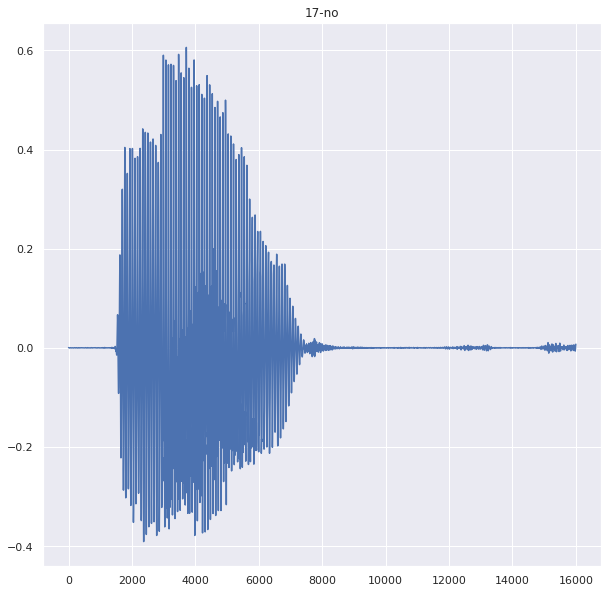

In [134]:
try:
  # Reading labels from labels.txt if generated
  with open("./models/labels.txt") as f:
      labels = f.readlines()
  labels = [i.strip() for i in labels]

  folders = os.listdir(test_dir)
  random_folder = random.choice(list(folders))
  random_file = random.choice(os.listdir(os.path.join(test_dir, random_folder).replace("\\", "/")))
  random_file = os.path.join(test_dir, random_folder, random_file).replace("\\", "/")
except:
  # Hardcoding the labels in the order in which they have been saved (alphabetically)
  labels = ["00-zero", "01-one", "02-two", "03-three", "04-four", "05-five", "06-six", "07-seven", "08-eight", "09-nine", "10-on", "11-off", "12-up", "13-down", "14-left", "15-right", "16-yes", "17-no"]
  random_label = random.choice(labels)
  random_file = random.choice(os.listdir(os.path.join(test_dir, random_label).replace("\\", "/")))
  random_file = os.path.join(test_dir, random_label, random_file).replace("\\", "/")

pred_index = run_tflite_model(tflite_quant_file, random_file, labels, print_info=True)

## Review and compare the quantized model performance

Let's compare all 3 models.

In [135]:
# Function to evaluate the TFLite model on all set samples
def evaluate_tflite_model(tflite_file, set_type, labels, model_type):
  predictions = []
  truths = []

  if set_type == "train":
    used_dir = dataset_dir
  elif set_type == "test":
    used_dir = test_dir
  else:
    raise ValueError

  for i, label in enumerate(labels):
    for filename in os.listdir(os.path.join(used_dir, label).replace("\\", "/")):
      file_full = os.path.join(used_dir, label, filename).replace("\\", "/")

      value = run_tflite_model(tflite_file, file_full, labels, print_info=False)
      predictions.append(value)
      truths.append(i)

  accuracy = sum(1 for x,y in zip(predictions, truths) if x==y)*100 / float(len(predictions))

  print("%s model accuracy is %.2f%% in %s set (Number of samples=%d)" % (model_type, accuracy, set_type, len(predictions)))
  
  return accuracy

In [136]:
# Normal TFLite model on train set
acc_tflite_normal_train = evaluate_tflite_model(tflite_file, "train", labels, "Normal TFLite")

Normal TFLite model accuracy is 89.68% in train set (Number of samples=24341)


In [137]:
# Normal TFLite model on test set
acc_tflite_normal_test = evaluate_tflite_model(tflite_file, "test", labels, "Normal TFLite")

Normal TFLite model accuracy is 88.17% in test set (Number of samples=16225)


In [138]:
# Quantized TFLite model on train set
acc_tflite_quantized_train = evaluate_tflite_model(tflite_quant_file, "train", labels, "Quantized TFLite")

Quantized TFLite model accuracy is 92.77% in train set (Number of samples=24341)


In [139]:
# Quantized TFLite model on test set
acc_tflite_quantized_train = evaluate_tflite_model(tflite_quant_file, "test", labels, "Quantized TFLite")

Quantized TFLite model accuracy is 91.31% in test set (Number of samples=16225)


**Original model:**
* train -> accuracy: 99.03%
* validation -> accuracy: 96.22%
* test -> accuracy: 96.92%

**Normal TFLite model:**
* train -> accuracy: 89.68%
* test -> accuracy: 88.17% 

**Quantized TFLite model:**
* train -> accuracy: 92.77%
* test -> loss: accuracy: 91.31%

-----

## Download the TF Lite models

In [140]:
!zip -r ./TL_models_ENG.zip ./models

  adding: models/ (stored 0%)
  adding: models/TL_model_quantized_MM_metadata.tflite (deflated 20%)
  adding: models/labels.txt (deflated 22%)
  adding: models/browserfft-speech.json (deflated 64%)
  adding: models/browserfft-speech.tflite (deflated 8%)
  adding: models/saved_model/ (stored 0%)
  adding: models/saved_model/saved_model.pb (deflated 90%)
  adding: models/saved_model/keras_metadata.pb (deflated 94%)
  adding: models/saved_model/assets/ (stored 0%)
  adding: models/saved_model/variables/ (stored 0%)
  adding: models/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: models/saved_model/variables/variables.index (deflated 60%)
  adding: models/TL_model_quantized_MM.tflite (deflated 20%)


In [142]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("/content/TL_original_model.png")
  files.download("/content/TL_models_ENG.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check out our end-to-end example apps that perform inferencing with TFLite audio models on [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/android/) and [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/ios).